## Goal and assumptions

- Start from the same product-level `df` used in the portfolio analysis (contains `product_id`, `product_name`, `loves_count`, `avg_sentiment`, `segment`, `price_usd`).
- Do not re-run raw-review sentiment calculations here; if `df` is not present, we will build it by merging `archive/product_info.csv` with `product_sent.csv` (pre-aggregated).

In [31]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

# Helper: small product-level builder (merges product metadata with precomputed product_sent)
def build_product_level_df(products_df: pd.DataFrame, sentiment_df: pd.DataFrame, join_type: str = 'left') -> pd.DataFrame:
    # Basic validation
    if 'product_id' not in products_df.columns:
        raise KeyError('products_df must contain product_id')
    if 'product_id' not in sentiment_df.columns:
        raise KeyError('sentiment_df must contain product_id')
    if 'avg_sentiment' not in sentiment_df.columns:
        raise KeyError('sentiment_df must contain avg_sentiment')
    df = products_df.merge(sentiment_df, on='product_id', how=join_type, validate='one_to_one')
    # Coerce common numeric cols
    for c in ['loves_count', 'price_usd', 'avg_sentiment', 'review_count', 'sentiment_review_count']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

# Locate or build `df` (product-level)
if 'df' in globals():
    print('Using `df` from notebook globals')
else:
    # Try to find a ready product-level CSV first
    candidates = ['product_level.csv', 'product_df.csv', 'df_products.csv']
    df = None
    for fn in candidates:
        if os.path.exists(fn):
            df = pd.read_csv(fn)
            print(f'Loaded product-level df from {fn} (rows={len(df)})')
            break
    if df is None:
        # Try to merge archive/product_info.csv + product_sent.csv (no raw reviews)
        prod_path = os.path.join('archive', 'product_info.csv')
        sent_path = 'product_sent.csv'
        if os.path.exists(prod_path) and os.path.exists(sent_path):
            products = pd.read_csv(prod_path, low_memory=False)
            product_sent = pd.read_csv(sent_path)
            df = build_product_level_df(products, product_sent, join_type='left')
            print(f'Built `df` by merging {prod_path} + {sent_path} (rows={len(df)})')
        else:
            raise FileNotFoundError('Could not find an existing product-level df nor product_sent.csv + archive/product_info.csv. Run the sentiment notebook first or provide product_sent.csv.')

# Normalize column names commonly used in downstream cells
# prefer `product_name` and `product_id` naming
if 'product_name_product' in df.columns and 'product_name' not in df.columns:
    df = df.rename(columns={'product_name_product': 'product_name'})
if 'id' in df.columns and 'product_id' not in df.columns:
    df = df.rename(columns={'id': 'product_id'})

print('Final product-level columns:', df.columns.tolist())
display(df.head())

Using `df` from notebook globals
Final product-level columns: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price', 'avg_sentiment', 'median_sentiment', 'positive_share', 'sentiment_review_count', 'price_band_x', 'price_band_y', 'log_loves', 'popularity_level', 'sentiment_level', 'segment', 'price_band']


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,median_sentiment,positive_share,sentiment_review_count,price_band_x,price_band_y,log_loves,popularity_level,sentiment_level,segment,price_band
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2,2,8.751633,Low,Low,Low Popularity / Low Sentiment,2
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,4,4,8.250098,Low,Low,Low Popularity / Low Sentiment,4
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,4,4,8.087640,Low,Low,Low Popularity / Low Sentiment,4
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,4,4,8.012681,Low,Low,Low Popularity / Low Sentiment,4
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,4,4,7.898040,Low,Low,Low Popularity / Low Sentiment,4


In [32]:
import numpy as np
import pandas as pd

# Ensure segment exists (popularity vs sentiment)
for c in ["loves_count", "avg_sentiment"]:
    if c not in df.columns:
        raise KeyError(
            f"df must contain '{c}' (compute product_sent or run the sentiment notebook first)"
        )

df["loves_count"] = pd.to_numeric(df["loves_count"], errors="coerce").fillna(0)
df["avg_sentiment"] = pd.to_numeric(df["avg_sentiment"], errors="coerce")

df["log_loves"] = np.log1p(df["loves_count"])

pop_thr = df["log_loves"].median()
sent_thr = df["avg_sentiment"].median()

df["popularity_level"] = np.where(df["log_loves"] >= pop_thr, "High", "Low")
df["sentiment_level"] = np.where(df["avg_sentiment"] >= sent_thr, "High", "Low")

df["segment"] = (
    df["popularity_level"]
    + " Popularity / "
    + df["sentiment_level"]
    + " Sentiment"
)

print(f"pop_thr={pop_thr:.3f}, sent_thr={sent_thr:.3f}")
print("Segments:")
print(df["segment"].value_counts())



pop_thr=9.198, sent_thr=0.678
Segments:
segment
High Popularity / Low Sentiment     3708
Low Popularity / Low Sentiment      3605
Low Popularity / High Sentiment      642
High Popularity / High Sentiment     539
Name: count, dtype: int64


## 1) Create price bands

We create quintile-based price bands (`pd.qcut`) so price positioning is relative across the catalog.

In [33]:
# Ensure numeric
import pandas as pd
import numpy as np

# coerce price
df["price_usd"] = pd.to_numeric(df["price_usd"], errors="coerce")

# Work only with products that have price
df_price = df.dropna(subset=["price_usd"]).copy()

# Create quintile bands (0=cheapest ... 4=most expensive)
try:
    df_price["price_band"] = pd.qcut(df_price["price_usd"], q=5, labels=False, duplicates="drop").astype("Int64")
except Exception as e:
    print('qcut failed, falling back to cut:', e)
    df_price["price_band"] = pd.cut(df_price["price_usd"], bins=5, labels=False)

# Attach back: drop existing price_band in df to avoid merge conflicts
if "price_band" in df.columns:
    df = df.drop(columns=["price_band"])

# Ensure product_id types match
if df['product_id'].dtype != df_price['product_id'].dtype:
    df_price['product_id'] = df_price['product_id'].astype(df['product_id'].dtype)

df = df.merge(df_price[["product_id", "price_band"]], on="product_id", how="left")

# Build range table with quantiles
price_band_ranges = (
    df_price.groupby("price_band")["price_usd"]
    .agg(
        min_price=("min"),
        q25=(lambda x: x.quantile(0.25)),
        median_price=("median"),
        q75=(lambda x: x.quantile(0.75)),
        max_price=("max"),
        count=("count"),
    )
    .reset_index()
)

# Add a readable label like "$3–$25"
price_band_ranges["price_range"] = (
    "$" + price_band_ranges["min_price"].round(2).astype(str)
    + " – $"
    + price_band_ranges["max_price"].round(2).astype(str)
)

print('Price band ranges:')
display(price_band_ranges)

# Summary of popularity by price band
price_summary = (
    df.groupby('price_band')
      .agg(
          product_count=('product_id', 'nunique'),
          median_loves=('loves_count', 'median'),
          mean_loves=('loves_count', 'mean')
      )
      .sort_index()
)
print('\nPrice summary by band:')
display(price_summary)

# Segment × Price band table
segment_price = (
    df.groupby(['segment', 'price_band'])
      .agg(
          products=('product_id', 'nunique'),
          median_loves=('loves_count', 'median'),
          avg_sentiment=('avg_sentiment', 'mean')
      )
      .reset_index()
)
print('\nSegment × price band:')
display(segment_price.sort_values(['segment', 'price_band']))

Price band ranges:


,price_band,min_price,q25,median_price,q75,max_price,count,price_range
0,0,3.0,13.0,16.0,20.0,22.0,1728,$3.0 – $22.0
1,1,22.5,25.0,27.0,29.0,30.0,1787,$22.5 – $30.0
2,2,30.8,33.0,35.0,38.0,40.0,1636,$30.8 – $40.0
3,3,40.5,45.0,50.0,59.0,69.0,1697,$40.5 – $69.0
4,4,70.0,85.0,110.0,149.0,1900.0,1646,$70.0 – $1900.0



Price summary by band:


,product_count,median_loves,mean_loves
price_band,,,
0,1728,12126.0,32990.230324
1,1787,12579.0,34301.941802
2,1636,10908.0,33133.633252
3,1697,9815.0,29627.516794
4,1646,5830.0,15226.017618



Segment × price band:


,segment,price_band,products,median_loves,avg_sentiment
0,High Popularity / High Sentiment,0,65,20995.0,0.748769
1,High Popularity / High Sentiment,1,74,23448.0,0.749514
2,High Popularity / High Sentiment,2,102,27924.5,0.749618
3,High Popularity / High Sentiment,3,203,22166.0,0.763493
4,High Popularity / High Sentiment,4,95,18261.0,0.748516
5,High Popularity / Low Sentiment,0,898,27948.5,0.562316
6,High Popularity / Low Sentiment,1,948,28387.0,0.565141
7,High Popularity / Low Sentiment,2,756,30622.0,0.578280
8,High Popularity / Low Sentiment,3,642,29334.0,0.592616
9,High Popularity / Low Sentiment,4,464,20340.0,0.585584


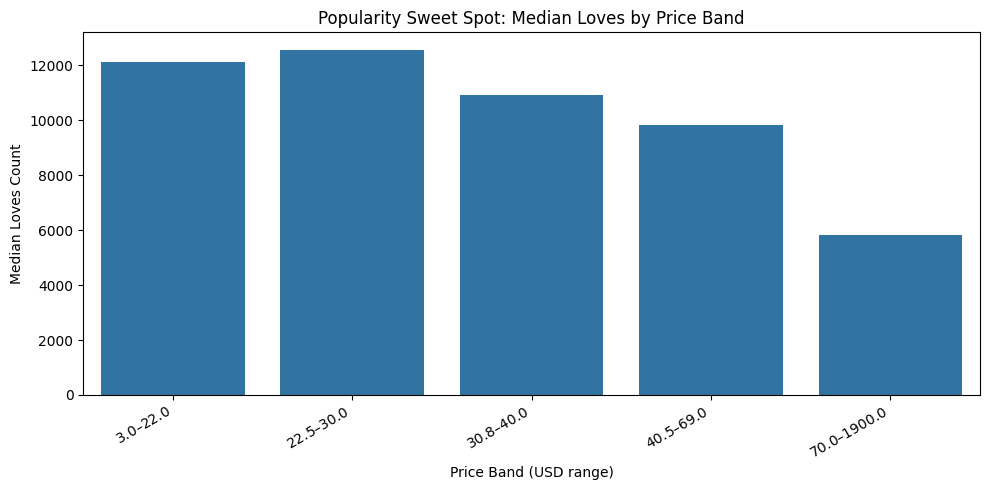

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# Build readable x-axis labels
# ---------------------------
band_to_range = dict(zip(price_band_ranges["price_band"], price_band_ranges["price_range"]))
price_band_order = sorted(band_to_range.keys())
x_labels = [band_to_range[b] for b in price_band_order]

# ---------------------------
# Plot 1: Sweet spot (median loves by price band)
# ---------------------------
plot_df = price_summary.reset_index().copy()
plot_df["price_range"] = plot_df["price_band"].map(band_to_range)
plot_df = plot_df.sort_values("price_band")

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="price_range", y="median_loves")
plt.title("Popularity Sweet Spot: Median Loves by Price Band")
plt.xlabel("Price Band (USD range)")
plt.ylabel("Median Loves Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure required objects exist; if not, recompute from `df`
if 'segment_price' not in globals():
    segment_price = (
        df.groupby(['segment', 'price_band'])
          .agg(
              products=('product_id', 'nunique'),
              median_loves=('loves_count', 'median'),
              avg_sentiment=('avg_sentiment', 'mean')
          )
          .reset_index()
    )

if 'price_band_ranges' not in globals():
    df_price_local = df.dropna(subset=['price_usd']).copy()
    try:
        df_price_local['price_band'] = pd.qcut(df_price_local['price_usd'], q=5, labels=False, duplicates='drop')
    except Exception:
        df_price_local['price_band'] = pd.cut(df_price_local['price_usd'], bins=5, labels=False)
    price_band_ranges = (
        df_price_local.groupby('price_band')['price_usd']
        .agg(min_price='min', median_price='median', max_price='max', count='count')
        .reset_index()
    )
    price_band_ranges['price_range'] = (
        '$' + price_band_ranges['min_price'].round(2).astype(str)
        + ' – $' + price_band_ranges['max_price'].round(2).astype(str)
    )

# Pivot tables for heatmaps
pivot_loves = segment_price.pivot(index='segment', columns='price_band', values='median_loves').fillna(0)
pivot_sent = segment_price.pivot(index='segment', columns='price_band', values='avg_sentiment')

# Order columns (price bands) and map labels
price_cols = sorted([c for c in pivot_loves.columns if pd.notna(c)])
col_labels = {pb: price_band_ranges.set_index('price_band')['price_range'].to_dict().get(pb, str(pb)) for pb in price_cols}

pivot_loves = pivot_loves.reindex(columns=price_cols)
pivot_sent = pivot_sent.reindex(columns=price_cols)

# Business-friendly ordering for segments (if present)
preferred_order = [
    'High Popularity / High Sentiment',
    'High Popularity / Low Sentiment',
    'Low Popularity / High Sentiment',
    'Low Popularity / Low Sentiment'
]
rows = [r for r in preferred_order if r in pivot_loves.index]
other_rows = [r for r in pivot_loves.index if r not in rows]
row_order = rows + other_rows
pivot_loves = pivot_loves.reindex(index=row_order)
pivot_sent = pivot_sent.reindex(index=row_order)

# Plot two heatmaps side-by-side
fig, axes = plt.subplots(ncols=2, figsize=(14, max(4, 0.6 * len(pivot_loves.index))))

sns.heatmap(pivot_loves, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Median Loves'})
axes[0].set_title('Median Loves by Segment × Price Band')
axes[0].set_xlabel('Price Band (USD range)')
axes[0].set_ylabel('Product Segment')
axes[0].set_xticklabels([col_labels.get(c, str(c)) for c in pivot_loves.columns], rotation=30, ha='right')

sns.heatmap(pivot_sent, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1], center=pivot_sent.stack().mean(), cbar_kws={'label': 'Avg Sentiment'})
axes[1].set_title('Average Sentiment by Segment × Price Band')
axes[1].set_xlabel('Price Band (USD range)')
axes[1].set_ylabel('')
axes[1].set_xticklabels([col_labels.get(c, str(c)) for c in pivot_sent.columns], rotation=30, ha='right')

plt.tight_layout()
plt.show()


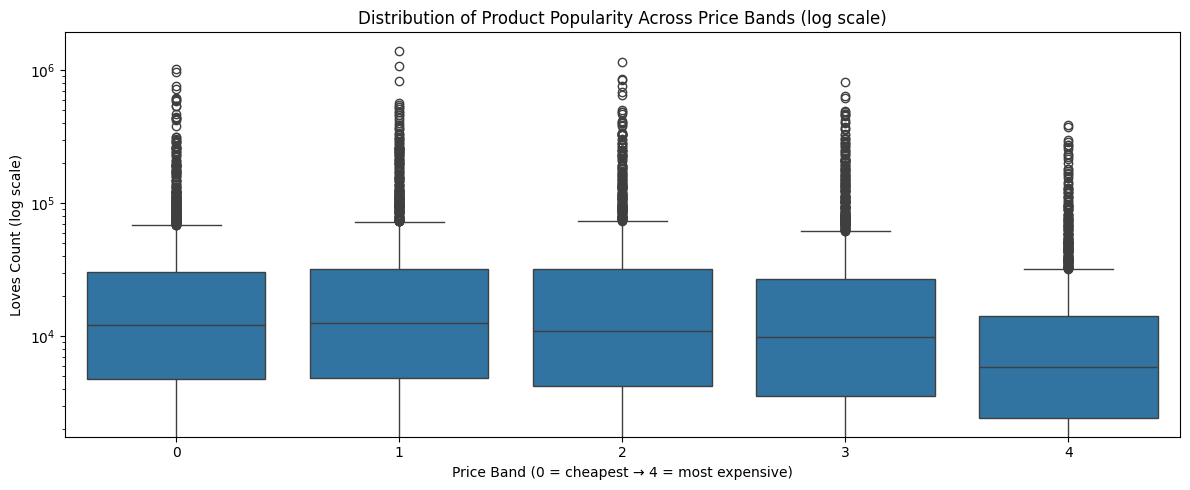

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(
    data=df,
    x="price_band",
    y="loves_count",
    showfliers=True
)
plt.yscale("log")
plt.title("Distribution of Product Popularity Across Price Bands (log scale)")
plt.xlabel("Price Band (0 = cheapest → 4 = most expensive)")
plt.ylabel("Loves Count (log scale)")
plt.tight_layout()
plt.show()

